In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import glob

import bvcopula

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
exp_pref = '{}_{}'.format(animal,day_name)
path = '/home/nina/models'

In [17]:
out_dir = '../models/'+exp_pref
with open(out_dir+'/summary.pkl','rb') as f:
    data = pkl.load(f)
n1=2
n2=20
data[n1+5,n2+5][0]

[FrankCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), IndependenceCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), GumbelCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

In [46]:
import warnings
import sys
import traceback
from tqdm import tqdm

def _get_copula(likelihood, f, sample_size): #likelihood method
    thetas, mixes = likelihood.gplink_function(f)
    thetas = thetas.expand(sample_size+thetas.shape)
    mixes = mixes.expand(sample_size+mixes.shape)
    thetas = torch.einsum('ijk->jki', thetas) # now: [copulas, positions, samples]
    mixes = torch.einsum('ijk->jki', mixes)
    copulas = [lik.copula for lik in likelihood.likelihoods]
    rotations = [lik.rotation for lik in likelihood.likelihoods]
    return likelihood.copula(thetas,mixes,copulas,rotations=rotations)
    
def _entropy_given_params(copula, alpha=0.05, sem_tol=1e-3): #copula_method
        # Gaussian confidence interval for sem_tol and level alpha
        conf = torch.erfinv(torch.tensor([1. - alpha]))
        sem = torch.ones(copula.theta.shape[1])*float('inf')
        ent = torch.zeros(copula.theta.shape[1])
        var_sum = torch.zeros(copula.theta.shape[1])
        log2 = torch.tensor([2.]).log()
        k = 0
        mc_size = copula.theta.shape[-1]
        with torch.no_grad():
            while torch.all(sem >= sem_tol):
                # Generate samples
                samples = copula.rsample()
                assert samples.dim()==3 # [conditioning_variable, samples, 2]
                logp = copula.log_prob(samples)
                assert torch.all(logp==logp)
                assert torch.all(logp.abs()!=float("inf")) #otherwise make masked tensor below
                log2p = logp / log2 #maybe should check for inf 2 lines earlier
                k += 1
                # Monte-Carlo estimate of entropy
                ent += (-log2p.mean(dim=(-1)) - ent) / k
                # Estimate standard error
                var_sum += ((-log2p.t() - ent) ** 2).sum(dim=0)
                sem = conf * (var_sum / (k * mc_size * (k * mc_size - 1))).pow(.5)
        return ent#, sem
    
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
        
def measure_MI(n1,n2,likelihoods,points,device,samp_mc_size=10000):
    get_weights_filename = glob.glob('{}/{}/model_{}-{}.pth'.format(path,exp_pref,n1,n2))
    print(get_weights_filename)
    if len(get_weights_filename)>0:
        if len(get_weights_filename)>1:
            print('There is more then 1 file, taking the first one')
        model = bvcopula.load_model(get_weights_filename[0], likelihoods, device)
        MIs = []
        with torch.no_grad():
            fs = model(points).rsample(torch.Size([20])) #[samples_f, copulas, positions]
        fs = torch.einsum('ijk->jik', fs) #[copulas, samples_f, positions] 
        f = fs.reshape((fs.shape[0],-1)) #[copulas, (samples_f x positions)]
        
        copula = _get_copula(model.likelihood, f, sample_size = torch.Size([samp_mc_size]))
        MI = _entropy_given_params(copula)
        MIs = MI.reshape(fs.shape[1:]) #[samples_f, positions]
        
        # MI for mean
        f = model(points).mean
        copula = _get_copula(model.likelihood, f, sample_size = torch.Size([samp_mc_size]))
        MI_mean = _entropy_given_params(copula)
        
        return (MI_mean,MIs.mean(dim=0),MIs.std(dim=0))
    else:
        print('Weights file {} not found.'.format(get_weights_filename))

warnings.showwarning = warn_with_traceback

points = torch.linspace(0,1,50)
        
n1=1
n2=12
%time (ym, y, dy) = measure_MI(n1, n2, data[n1+5,n2+5][0], points, torch.device('cpu'))

['/home/nina/models/ST263_Day4/model_1-12.pth']
CPU times: user 44min 50s, sys: 4min 36s, total: 49min 27s
Wall time: 4min 13s


(-0.5, 0)

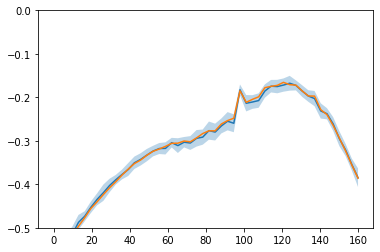

In [48]:
plt.plot(np.linspace(0,160,len(y)),y)
plt.fill_between(np.linspace(0,160,len(y)),y-dy,y+dy, alpha=0.3)
plt.plot(np.linspace(0,160,len(ym)),ym)
plt.ylim(-.5,0)